In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
sharedSizes=[1024]
dSpecific_filter=[(200,16)]
pID_type='randInit'
pIDemb_size=64

In [3]:
holdOutSamples=['HV1','P22','P14','P27']

In [4]:
sourceDir='/data/xinyi/c2p/data/chromark'
segDir=os.path.join(sourceDir,'nuclear_masks')
imgDir=os.path.join(sourceDir,'raw_data')
conditions=['controls','headneck','meningioma', 'glioma']

outSize=128
savename='pathCentered_'+str(outSize)

imgsC_all=None
imgsP_all=None
imgNames_all=None
proteinNames=None
pID_all=None
for condition_i in conditions:
    print(condition_i)
    segDir_i=os.path.join(segDir,condition_i)
    imgDir_i=os.path.join(imgDir,condition_i)
    for stain in os.listdir(segDir_i):
        print(stain)
        segDir_i_stain=os.path.join(segDir_i,stain)
        imgDir_i_stain=os.path.join(imgDir_i,stain)
        
        segPID2name={}
        for pID_dir in os.listdir(segDir_i_stain):
            pID=pID_dir.split('_')
            segPID2name[pID[0]]=pID_dir
        imgPID2name={}
        for pID_dir in os.listdir(imgDir_i_stain):
            pID=pID_dir.split('_')
            imgPID2name[pID[0]]=pID_dir
        for pID in segPID2name.keys():
            if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                continue
            if pID in holdOutSamples:
                print('hold out: '+pID)
                continue
            print(pID)
            if pID not in imgPID2name:
                print('img not found '+pID)
                continue
            imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
            segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])
            
            with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                imgNames=pickle.load(output)
            with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                img=pickle.load(output)

            imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
            proteinNames_curr=np.array([])
            stain_list=stain.split('_')
            nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
            np.random.seed(3)
            allIdx_all=np.arange(img.shape[0])
            np.random.shuffle(allIdx_all)
            for s in range(1,len(stain_list)):
                s_start=(s-1)*nImgPerStain
                if s==len(stain_list)-1:
                    s_end=img.shape[0]
                else:
                    s_end=s*nImgPerStain
                imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                proteinNames_curr=np.concatenate((proteinNames_curr,np.repeat(stain_list[s],s_end-s_start)))
            
            if pID_all is None:
                pID_all=np.repeat(pID,img.shape[0])
                imgsC_all=img[allIdx_all,[0]]
                imgNames_all=imgNames[allIdx_all]
                proteinNames=proteinNames_curr
                imgsP_all=imgP
            else:
                pID_all=np.concatenate((pID_all,np.repeat(pID,img.shape[0])))
                imgsC_all=np.concatenate((imgsC_all,img[allIdx_all,[0]]),axis=0)
                imgNames_all=np.concatenate((imgNames_all,imgNames[allIdx_all]))
                proteinNames=np.concatenate((proteinNames,proteinNames_curr))
                imgsP_all=np.concatenate((imgsP_all,imgP),axis=0)
imgsC_all=imgsC_all.reshape(imgsC_all.shape[0],1,imgsC_all.shape[1],imgsC_all.shape[2])

controls
dapi_gh2ax_lamin
HV5
HV4
HV2
HV10
hold out: HV1
HV7
HV9
HV8
HV3
HV6
dapi_cd8_cd4
hold out: HV1
HV8
HV6
HV7
HV4
HV5
HV3
HV2
headneck
dapi_gh2ax_lamin_cd3
P72
P63
hold out: P14
P44
P41
P56
P18
P55
P50
P24
dapi_cd16_cd4_cd8
P55
P56
P72
hold out: P14
P18
P41
P44
P63
P50
P24
meningioma
dapi_gh2ax_lamin_cd3
hold out: P27
P70
P83
P42
P59
P38
P48
P37
P62
dapi_cd16_cd4_cd8
P42
P48
P62
P38
P83
P37
P33
P70
P59
hold out: P27
glioma
dapi_gh2ax_lamin_cd3
P46
P16
P52
hold out: P22
P84
P47
P57
P15
P29
img not found P29
P68
dapi_cd16_cd4_cd8
P46
P47
P29
P52
P57
hold out: P22
P68
P16
P84
P15


In [5]:
imgsC_val=None
imgsP_val=None
imgNames_val=None
proteinNames_val=None
pID_val=None
imgsP_val_all=None
imgsP_val_all_names=None
for condition_i in conditions:
    print(condition_i)
    segDir_i=os.path.join(segDir,condition_i)
    imgDir_i=os.path.join(imgDir,condition_i)
    for stain in os.listdir(segDir_i):
        print(stain)
        segDir_i_stain=os.path.join(segDir_i,stain)
        imgDir_i_stain=os.path.join(imgDir_i,stain)
        
        segPID2name={}
        for pID_dir in os.listdir(segDir_i_stain):
            pID=pID_dir.split('_')
            segPID2name[pID[0]]=pID_dir
        imgPID2name={}
        for pID_dir in os.listdir(imgDir_i_stain):
            pID=pID_dir.split('_')
            imgPID2name[pID[0]]=pID_dir
        for pID in segPID2name.keys():
            if condition_i=='meningioma' and stain=='dapi_gh2ax_lamin_cd3' and pID=='P33': #skipping incorrect images
                continue
            if pID not in holdOutSamples:
                continue
            print(pID)
            if pID not in imgPID2name:
                print('img not found '+pID)
                continue
            imgDir_i_stain_p=os.path.join(imgDir_i_stain,imgPID2name[pID])
            segDir_i_stain_p=os.path.join(segDir_i_stain,segPID2name[pID])
            
            with open(os.path.join(imgDir_i_stain_p,savename+'_imgNames'), 'rb') as output:
                imgNames=pickle.load(output)
            with open(os.path.join(imgDir_i_stain_p,savename+'_img'), 'rb') as output:
                img=pickle.load(output)

            imgP=np.zeros((img.shape[0],1,img.shape[2],img.shape[3]))
            imgP_all=np.zeros((img.shape[0],3,img.shape[2],img.shape[3]))
            proteinNames_val_curr=np.array([])
            imgsP_val_all_names_curr=None
            stain_list=stain.split('_')
            nImgPerStain=int(img.shape[0]/(len(stain_list)-1))
            np.random.seed(3)
            allIdx_all=np.arange(img.shape[0])
            np.random.shuffle(allIdx_all)
            for s in range(1,len(stain_list)):
                s_start=(s-1)*nImgPerStain
                if s==len(stain_list)-1:
                    s_end=img.shape[0]
                else:
                    s_end=s*nImgPerStain
                imgP[s_start:s_end]=img[allIdx_all[s_start:s_end],s].reshape(s_end-s_start,1,img.shape[2],img.shape[3])
                proteinNames_val_curr=np.concatenate((proteinNames_val_curr,np.repeat(stain_list[s],s_end-s_start)))
                imgP_all[s_start:s_end,:img.shape[1]-1]=img[allIdx_all[s_start:s_end],1:].reshape(s_end-s_start,img.shape[1]-1,img.shape[2],img.shape[3])
                if imgsP_val_all_names_curr is None:
                    imgsP_val_all_names_curr=np.tile(stain_list[1:],(s_end-s_start,1))
                else:
                    imgsP_val_all_names_curr=np.concatenate((imgsP_val_all_names_curr,np.tile(stain_list[1:],(s_end-s_start,1))),axis=0)
            if imgsP_val_all_names_curr.shape[1]==2:
                imgsP_val_all_names_curr=np.hstack((imgsP_val_all_names_curr,np.repeat('None',imgsP_val_all_names_curr.shape[0]).reshape(-1,1)))
            if pID_val is None:
                pID_val=np.repeat(pID,img.shape[0])
                imgsC_val=img[allIdx_all,[0]]
                imgNames_val=imgNames[allIdx_all]
                proteinNames_val=proteinNames_val_curr
                imgsP_val=imgP
                imgsP_val_all=imgP_all
                imgsP_val_all_names=imgsP_val_all_names_curr
            else:
                pID_val=np.concatenate((pID_val,np.repeat(pID,img.shape[0])))
                imgsC_val=np.concatenate((imgsC_val,img[allIdx_all,[0]]),axis=0)
                imgNames_val=np.concatenate((imgNames_val,imgNames[allIdx_all]))
                proteinNames_val=np.concatenate((proteinNames_val,proteinNames_val_curr))
                imgsP_val=np.concatenate((imgsP_val,imgP),axis=0)
                imgsP_val_all=np.concatenate((imgsP_val_all,imgP_all),axis=0)
                imgsP_val_all_names=np.concatenate((imgsP_val_all_names,imgsP_val_all_names_curr),axis=0)
imgsC_val=imgsC_val.reshape(imgsC_val.shape[0],1,imgsC_val.shape[1],imgsC_val.shape[2])

controls
dapi_gh2ax_lamin
HV1
dapi_cd8_cd4
HV1
headneck
dapi_gh2ax_lamin_cd3
P14
dapi_cd16_cd4_cd8
P14
meningioma
dapi_gh2ax_lamin_cd3
P27
dapi_cd16_cd4_cd8
P27
glioma
dapi_gh2ax_lamin_cd3
P22
dapi_cd16_cd4_cd8
P22


In [6]:
nProt=np.unique(proteinNames).size
pnames,revIdx,pCounts=np.unique(proteinNames,return_inverse=True,return_counts=True)
plabels=torch.tensor(np.arange(pnames.size)[revIdx]).long()

In [7]:
nProt_val=np.unique(proteinNames_val).size
pnames_val,revIdx_val,pCounts_val=np.unique(proteinNames_val,return_inverse=True,return_counts=True)
plabels_val=torch.tensor(np.arange(pnames_val.size)[revIdx_val]).long()

In [8]:
nProt==nProt_val

True

In [9]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [10]:
#VAE settings
seed=3
epochs=5001
saveFreq=100
lr=0.001 #initial learning rate
weight_decay=0 #Weight for L2 loss on embedding matrix.

# batchsize=4
batchsize=256
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
hidden5_xy=4
fc_dim1=96*hidden5_xy*hidden5_xy
fc_dim2=6000

dropout=0.01
kl_weight=0.0000001





In [11]:
trainIdx=np.arange(imgsC_all.shape[0])
printFreq=1
valIdx=np.arange(imgsC_val.shape[0])
def train(epoch):
    t = time.time()
    modelcnn_dna.train()
    modelcnn_protein.train()

    loss_x_train_all_dna=0
    loss_x_trainShared_all_dna=0
    loss_x_train_all_protein=0
    loss_x_trainShared_all_protein=0
    loss_all=0
    ntrainBatches=int(np.ceil(trainIdx.shape[0]/batchsize))
    for i in range(ntrainBatches):
#         if i%200==0:
#         print(i)
        trainIdx_i=trainIdx[i*batchsize:min((i+1)*batchsize,trainIdx.shape[0])]
        traintarget_protein=torch.tensor(imgsP_all[trainIdx_i]).cuda().float()
        trainIdx_i=torch.tensor(trainIdx_i)
        traintarget_dna=torch.tensor(imgsC_all[trainIdx_i]).cuda().float()
        trainInput_ID=plabels[trainIdx_i].cuda()
        trainInput_shared=latent_shared_dec(trainIdx_i).cuda().float()
        trainInput_dna=latent_dna_dec(trainIdx_i).cuda().float()
        trainInput_protein=latent_protein_dec(trainIdx_i).cuda().float()
#         print(trainInput.shape)

        optimizer_dna.zero_grad()
        optimizer_protein.zero_grad()

        reconShared_dna,recon_dna= modelcnn_dna(traintarget_dna,trainInput_ID)
        reconShared_protein,recon_protein= modelcnn_protein(traintarget_protein,trainInput_ID)
        
        loss_x_train_protein=loss_x(recon_protein, trainInput_protein)
        loss_xShared_train_protein=loss_x(reconShared_protein,trainInput_shared)
        loss_x_train_dna=loss_x(recon_dna, trainInput_dna)
        loss_xShared_train_dna=loss_x(reconShared_dna,trainInput_shared)
        
        loss=loss_x_train_protein+loss_xShared_train_protein+loss_x_train_dna+loss_xShared_train_dna
        
        loss_x_train_all_dna+=loss_x_train_dna.item()
        loss_x_trainShared_all_dna+=loss_xShared_train_dna.item()
        loss_x_train_all_protein+=loss_x_train_protein.item()
        loss_x_trainShared_all_protein+=loss_xShared_train_protein.item()
        loss_all+=loss.item()
        
        loss.backward()
        optimizer_dna.step()
        optimizer_protein.step()


    loss_x_train_all_dna=loss_x_train_all_dna/ntrainBatches
    loss_x_trainShared_all_dna=loss_x_trainShared_all_dna/ntrainBatches
    loss_x_train_all_protein=loss_x_train_all_protein/ntrainBatches
    loss_x_trainShared_all_protein=loss_x_trainShared_all_protein/ntrainBatches
    loss_all=loss_all/ntrainBatches

    with torch.no_grad():
        modelcnn_dna.eval()
        modelcnn_protein.eval()



        loss_val_all=0
        loss_x_val_all_dna=0
        loss_x_valShared_all_dna=0
        loss_x_val_all_protein=0
        loss_x_valShared_all_protein=0
        nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
            valtarget_protein=torch.tensor(imgsP_val[valIdx_i]).cuda().float()
            valtarget_dna=torch.tensor(imgsC_val[valIdx_i]).cuda().float()
            valInput_ID=plabels_val[valIdx_i].cuda()
            valIdx_i=torch.tensor(valIdx_i)

            reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)
            reconShared_protein_l,recon_protein_l= modelcnn_protein(valtarget_protein,valInput_ID)
            
            recon_dna= modelcnn_dna_dec(torch.cat((reconShared_dna_l,recon_dna_l),dim=1),pIDemb_dec(valInput_ID))
            reconShared_dna=modelcnn_dnaShared_dec(reconShared_dna_l,pIDemb_dec(valInput_ID))
            recon_protein= modelcnn_protein_dec(torch.cat((reconShared_protein_l,recon_protein_l),dim=1),pIDemb_dec(valInput_ID))
            reconShared_protein=modelcnn_pShared_dec(reconShared_protein_l,pIDemb_dec(valInput_ID))


            loss_x_val_protein=loss_x(recon_protein, valtarget_protein)
            loss_xShared_val_protein=loss_x(reconShared_protein,valtarget_protein)
            loss_x_val_dna=loss_x(recon_dna, valtarget_dna)
            loss_xShared_val_dna=loss_x(reconShared_dna,valtarget_dna)

            loss=loss_x_val_protein+loss_xShared_val_protein+loss_x_val_dna+loss_xShared_val_dna

            loss_x_val_all_dna+=loss_x_val_dna.item()
            loss_x_valShared_all_dna+=loss_xShared_val_dna.item()
            loss_x_val_all_protein+=loss_x_val_protein.item()
            loss_x_valShared_all_protein+=loss_xShared_val_protein.item()
            loss_val_all+=loss.item()

        loss_x_val_all_dna=loss_x_val_all_dna/nvalBatches
        loss_x_valShared_all_dna=loss_x_valShared_all_dna/nvalBatches
        loss_x_val_all_protein=loss_x_val_all_protein/nvalBatches
        loss_x_valShared_all_protein=loss_x_valShared_all_protein/nvalBatches
        loss_val_all=loss_val_all/nvalBatches



    if epoch%printFreq==0:
        print('Epoch: {:04d}'.format(epoch),
              'loss_train: {:.4f}'.format(loss_all),
              'loss_x_train_dna: {:.4f}'.format(loss_x_train_all_dna),
              'loss_x_train_protein: {:.4f}'.format(loss_x_train_all_protein),
              'loss_xShared_train_dna: {:.4f}'.format(loss_x_trainShared_all_dna),
              'loss_xShared_train_protein: {:.4f}'.format(loss_x_trainShared_all_protein),
              'loss_x_val_dna: {:.4f}'.format(loss_x_val_all_dna),
              'loss_x_val_protein: {:.4f}'.format(loss_x_val_all_protein),
              'loss_xShared_val_dna: {:.4f}'.format(loss_x_valShared_all_dna),
              'loss_xShared_val_protein: {:.4f}'.format(loss_x_valShared_all_protein),
              'time: {:.4f}s'.format(time.time() - t))
    return loss_all,loss_x_train_all_dna,loss_x_train_all_protein,loss_x_trainShared_all_dna,loss_x_trainShared_all_protein,loss_val_all,loss_x_val_all_dna,loss_x_val_all_protein,loss_x_valShared_all_dna,loss_x_valShared_all_protein

In [12]:
match_weight=1
sharedWeight=1
name_train='splitChannels_conditional_lord_withNoise'
modelname_train='cnn_vae_pbmc_lord'
logsavepath_train=os.path.join('/data/xinyi/c2p/log/',modelname_train,name_train)
modelsavepath_train=os.path.join('/data/xinyi/c2p/models/',modelname_train,name_train)
plotsavepath_train=os.path.join('/data/xinyi/c2p/plots/',modelname_train,name_train)

if not os.path.exists(os.path.join('/data/xinyi/c2p/log/',modelname_train)):
    os.mkdir(os.path.join('/data/xinyi/c2p/log/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/models/',modelname_train))
    os.mkdir(os.path.join('/data/xinyi/c2p/plots/',modelname_train))
if not os.path.exists(logsavepath_train):
    os.mkdir(logsavepath_train)
    os.mkdir(os.path.join(logsavepath_train,'dna'))
    os.mkdir(os.path.join(logsavepath_train,'protein'))
if not os.path.exists(modelsavepath_train):
    os.mkdir(modelsavepath_train)
    os.mkdir(os.path.join(modelsavepath_train,'dna'))
    os.mkdir(os.path.join(modelsavepath_train,'protein'))
if not os.path.exists(plotsavepath_train):
    os.mkdir(plotsavepath_train)
    os.mkdir(os.path.join(plotsavepath_train,'dna'))
    os.mkdir(os.path.join(plotsavepath_train,'protein'))


loadEpoch='2699'


1024
200
Epoch: 0000 loss_train: 6.6676 loss_x_train_dna: 0.8151 loss_x_train_protein: 0.5835 loss_xShared_train_dna: 2.4345 loss_xShared_train_protein: 2.8345 loss_x_val_dna: 0.0051 loss_x_val_protein: 0.0102 loss_xShared_val_dna: 0.0049 loss_xShared_val_protein: 0.0097 time: 20.1424s
Epoch: 0001 loss_train: 6.1364 loss_x_train_dna: 0.7741 loss_x_train_protein: 0.5637 loss_xShared_train_dna: 2.0807 loss_xShared_train_protein: 2.7180 loss_x_val_dna: 0.0039 loss_x_val_protein: 0.0054 loss_xShared_val_dna: 0.0037 loss_xShared_val_protein: 0.0050 time: 21.4598s
Epoch: 0002 loss_train: 5.9211 loss_x_train_dna: 0.7588 loss_x_train_protein: 0.5610 loss_xShared_train_dna: 1.9974 loss_xShared_train_protein: 2.6039 loss_x_val_dna: 0.0032 loss_x_val_protein: 0.0056 loss_xShared_val_dna: 0.0031 loss_xShared_val_protein: 0.0052 time: 19.3245s
Epoch: 0003 loss_train: 5.8117 loss_x_train_dna: 0.7487 loss_x_train_protein: 0.5589 loss_xShared_train_dna: 1.9625 loss_xShared_train_protein: 2.5416 loss_x

Epoch: 0030 loss_train: 5.1119 loss_x_train_dna: 0.6975 loss_x_train_protein: 0.5307 loss_xShared_train_dna: 1.6952 loss_xShared_train_protein: 2.1885 loss_x_val_dna: 0.0027 loss_x_val_protein: 0.0038 loss_xShared_val_dna: 0.0027 loss_xShared_val_protein: 0.0034 time: 13.1832s
Epoch: 0031 loss_train: 5.0981 loss_x_train_dna: 0.6967 loss_x_train_protein: 0.5301 loss_xShared_train_dna: 1.6922 loss_xShared_train_protein: 2.1791 loss_x_val_dna: 0.0028 loss_x_val_protein: 0.0036 loss_xShared_val_dna: 0.0028 loss_xShared_val_protein: 0.0033 time: 12.8327s
Epoch: 0032 loss_train: 5.0896 loss_x_train_dna: 0.6963 loss_x_train_protein: 0.5298 loss_xShared_train_dna: 1.6897 loss_xShared_train_protein: 2.1738 loss_x_val_dna: 0.0028 loss_x_val_protein: 0.0033 loss_xShared_val_dna: 0.0028 loss_xShared_val_protein: 0.0031 time: 12.6862s
Epoch: 0033 loss_train: 5.0859 loss_x_train_dna: 0.6956 loss_x_train_protein: 0.5295 loss_xShared_train_dna: 1.6870 loss_xShared_train_protein: 2.1738 loss_x_val_dna:

Epoch: 0060 loss_train: 4.8358 loss_x_train_dna: 0.6774 loss_x_train_protein: 0.5171 loss_xShared_train_dna: 1.6084 loss_xShared_train_protein: 2.0329 loss_x_val_dna: 0.0029 loss_x_val_protein: 0.0033 loss_xShared_val_dna: 0.0029 loss_xShared_val_protein: 0.0032 time: 11.9679s
Epoch: 0061 loss_train: 4.8299 loss_x_train_dna: 0.6768 loss_x_train_protein: 0.5169 loss_xShared_train_dna: 1.6089 loss_xShared_train_protein: 2.0272 loss_x_val_dna: 0.0030 loss_x_val_protein: 0.0032 loss_xShared_val_dna: 0.0030 loss_xShared_val_protein: 0.0031 time: 11.8401s
Epoch: 0062 loss_train: 4.8371 loss_x_train_dna: 0.6770 loss_x_train_protein: 0.5166 loss_xShared_train_dna: 1.6229 loss_xShared_train_protein: 2.0206 loss_x_val_dna: 0.0034 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0035 loss_xShared_val_protein: 0.0031 time: 11.8207s
Epoch: 0063 loss_train: 4.8178 loss_x_train_dna: 0.6764 loss_x_train_protein: 0.5158 loss_xShared_train_dna: 1.6144 loss_xShared_train_protein: 2.0112 loss_x_val_dna:

Epoch: 0090 loss_train: 4.6344 loss_x_train_dna: 0.6573 loss_x_train_protein: 0.5038 loss_xShared_train_dna: 1.5680 loss_xShared_train_protein: 1.9054 loss_x_val_dna: 0.0026 loss_x_val_protein: 0.0034 loss_xShared_val_dna: 0.0026 loss_xShared_val_protein: 0.0033 time: 12.5106s
Epoch: 0091 loss_train: 4.6274 loss_x_train_dna: 0.6560 loss_x_train_protein: 0.5035 loss_xShared_train_dna: 1.5648 loss_xShared_train_protein: 1.9031 loss_x_val_dna: 0.0026 loss_x_val_protein: 0.0036 loss_xShared_val_dna: 0.0026 loss_xShared_val_protein: 0.0034 time: 12.0011s
Epoch: 0092 loss_train: 4.6103 loss_x_train_dna: 0.6548 loss_x_train_protein: 0.5025 loss_xShared_train_dna: 1.5596 loss_xShared_train_protein: 1.8934 loss_x_val_dna: 0.0027 loss_x_val_protein: 0.0036 loss_xShared_val_dna: 0.0026 loss_xShared_val_protein: 0.0034 time: 13.2570s
Epoch: 0093 loss_train: 4.5989 loss_x_train_dna: 0.6538 loss_x_train_protein: 0.5022 loss_xShared_train_dna: 1.5552 loss_xShared_train_protein: 1.8876 loss_x_val_dna:

Epoch: 0120 loss_train: 4.4546 loss_x_train_dna: 0.6333 loss_x_train_protein: 0.4920 loss_xShared_train_dna: 1.5201 loss_xShared_train_protein: 1.8092 loss_x_val_dna: 0.0029 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0029 loss_xShared_val_protein: 0.0031 time: 11.5182s
Epoch: 0121 loss_train: 4.4529 loss_x_train_dna: 0.6323 loss_x_train_protein: 0.4922 loss_xShared_train_dna: 1.5189 loss_xShared_train_protein: 1.8095 loss_x_val_dna: 0.0030 loss_x_val_protein: 0.0032 loss_xShared_val_dna: 0.0030 loss_xShared_val_protein: 0.0032 time: 11.4959s
Epoch: 0122 loss_train: 4.4421 loss_x_train_dna: 0.6314 loss_x_train_protein: 0.4916 loss_xShared_train_dna: 1.5185 loss_xShared_train_protein: 1.8007 loss_x_val_dna: 0.0028 loss_x_val_protein: 0.0035 loss_xShared_val_dna: 0.0029 loss_xShared_val_protein: 0.0034 time: 11.5315s
Epoch: 0123 loss_train: 4.4412 loss_x_train_dna: 0.6310 loss_x_train_protein: 0.4910 loss_xShared_train_dna: 1.5179 loss_xShared_train_protein: 1.8012 loss_x_val_dna:

Epoch: 0150 loss_train: 4.3314 loss_x_train_dna: 0.6149 loss_x_train_protein: 0.4829 loss_xShared_train_dna: 1.4925 loss_xShared_train_protein: 1.7412 loss_x_val_dna: 0.0027 loss_x_val_protein: 0.0033 loss_xShared_val_dna: 0.0027 loss_xShared_val_protein: 0.0032 time: 16.1469s
Epoch: 0151 loss_train: 4.3245 loss_x_train_dna: 0.6145 loss_x_train_protein: 0.4827 loss_xShared_train_dna: 1.4914 loss_xShared_train_protein: 1.7358 loss_x_val_dna: 0.0027 loss_x_val_protein: 0.0033 loss_xShared_val_dna: 0.0027 loss_xShared_val_protein: 0.0033 time: 16.1101s
Epoch: 0152 loss_train: 4.3184 loss_x_train_dna: 0.6138 loss_x_train_protein: 0.4821 loss_xShared_train_dna: 1.4901 loss_xShared_train_protein: 1.7324 loss_x_val_dna: 0.0029 loss_x_val_protein: 0.0033 loss_xShared_val_dna: 0.0029 loss_xShared_val_protein: 0.0033 time: 16.8215s
Epoch: 0153 loss_train: 4.3188 loss_x_train_dna: 0.6132 loss_x_train_protein: 0.4819 loss_xShared_train_dna: 1.4894 loss_xShared_train_protein: 1.7343 loss_x_val_dna:

Epoch: 0180 loss_train: 4.2493 loss_x_train_dna: 0.6009 loss_x_train_protein: 0.4769 loss_xShared_train_dna: 1.4718 loss_xShared_train_protein: 1.6997 loss_x_val_dna: 0.0027 loss_x_val_protein: 0.0032 loss_xShared_val_dna: 0.0027 loss_xShared_val_protein: 0.0032 time: 29.5978s
Epoch: 0181 loss_train: 4.2424 loss_x_train_dna: 0.6007 loss_x_train_protein: 0.4764 loss_xShared_train_dna: 1.4706 loss_xShared_train_protein: 1.6947 loss_x_val_dna: 0.0027 loss_x_val_protein: 0.0032 loss_xShared_val_dna: 0.0027 loss_xShared_val_protein: 0.0033 time: 30.9279s
Epoch: 0182 loss_train: 4.2407 loss_x_train_dna: 0.6002 loss_x_train_protein: 0.4762 loss_xShared_train_dna: 1.4712 loss_xShared_train_protein: 1.6931 loss_x_val_dna: 0.0027 loss_x_val_protein: 0.0032 loss_xShared_val_dna: 0.0027 loss_xShared_val_protein: 0.0033 time: 30.5775s
Epoch: 0183 loss_train: 4.2390 loss_x_train_dna: 0.6001 loss_x_train_protein: 0.4759 loss_xShared_train_dna: 1.4728 loss_xShared_train_protein: 1.6902 loss_x_val_dna:

Epoch: 0210 loss_train: 4.1778 loss_x_train_dna: 0.5884 loss_x_train_protein: 0.4719 loss_xShared_train_dna: 1.4521 loss_xShared_train_protein: 1.6655 loss_x_val_dna: 0.0026 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0026 loss_xShared_val_protein: 0.0032 time: 30.9800s
Epoch: 0211 loss_train: 4.1743 loss_x_train_dna: 0.5882 loss_x_train_protein: 0.4718 loss_xShared_train_dna: 1.4513 loss_xShared_train_protein: 1.6630 loss_x_val_dna: 0.0026 loss_x_val_protein: 0.0033 loss_xShared_val_dna: 0.0026 loss_xShared_val_protein: 0.0034 time: 27.0963s
Epoch: 0212 loss_train: 4.1686 loss_x_train_dna: 0.5875 loss_x_train_protein: 0.4714 loss_xShared_train_dna: 1.4504 loss_xShared_train_protein: 1.6594 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0032 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 29.7510s
Epoch: 0213 loss_train: 4.1640 loss_x_train_dna: 0.5872 loss_x_train_protein: 0.4711 loss_xShared_train_dna: 1.4507 loss_xShared_train_protein: 1.6551 loss_x_val_dna:

Epoch: 0244 loss_train: 4.1014 loss_x_train_dna: 0.5776 loss_x_train_protein: 0.4660 loss_xShared_train_dna: 1.4367 loss_xShared_train_protein: 1.6211 loss_x_val_dna: 0.0026 loss_x_val_protein: 0.0033 loss_xShared_val_dna: 0.0027 loss_xShared_val_protein: 0.0034 time: 32.2067s
Epoch: 0245 loss_train: 4.0982 loss_x_train_dna: 0.5772 loss_x_train_protein: 0.4658 loss_xShared_train_dna: 1.4357 loss_xShared_train_protein: 1.6195 loss_x_val_dna: 0.0026 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0026 loss_xShared_val_protein: 0.0032 time: 33.1717s
Epoch: 0246 loss_train: 4.0950 loss_x_train_dna: 0.5769 loss_x_train_protein: 0.4655 loss_xShared_train_dna: 1.4356 loss_xShared_train_protein: 1.6169 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0031 time: 31.0350s
Epoch: 0247 loss_train: 4.0978 loss_x_train_dna: 0.5769 loss_x_train_protein: 0.4652 loss_xShared_train_dna: 1.4362 loss_xShared_train_protein: 1.6195 loss_x_val_dna:

Epoch: 0274 loss_train: 4.0612 loss_x_train_dna: 0.5702 loss_x_train_protein: 0.4625 loss_xShared_train_dna: 1.4292 loss_xShared_train_protein: 1.5993 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0032 time: 32.9752s
Epoch: 0275 loss_train: 4.0652 loss_x_train_dna: 0.5701 loss_x_train_protein: 0.4624 loss_xShared_train_dna: 1.4298 loss_xShared_train_protein: 1.6028 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 34.0480s
Epoch: 0276 loss_train: 4.0636 loss_x_train_dna: 0.5701 loss_x_train_protein: 0.4624 loss_xShared_train_dna: 1.4299 loss_xShared_train_protein: 1.6012 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0032 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 31.0629s
Epoch: 0277 loss_train: 4.0635 loss_x_train_dna: 0.5705 loss_x_train_protein: 0.4624 loss_xShared_train_dna: 1.4305 loss_xShared_train_protein: 1.6001 loss_x_val_dna:

Epoch: 0304 loss_train: 4.0253 loss_x_train_dna: 0.5636 loss_x_train_protein: 0.4600 loss_xShared_train_dna: 1.4202 loss_xShared_train_protein: 1.5814 loss_x_val_dna: 0.0024 loss_x_val_protein: 0.0032 loss_xShared_val_dna: 0.0024 loss_xShared_val_protein: 0.0035 time: 30.5526s
Epoch: 0305 loss_train: 4.0292 loss_x_train_dna: 0.5635 loss_x_train_protein: 0.4601 loss_xShared_train_dna: 1.4205 loss_xShared_train_protein: 1.5851 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 30.8879s
Epoch: 0306 loss_train: 4.0277 loss_x_train_dna: 0.5636 loss_x_train_protein: 0.4598 loss_xShared_train_dna: 1.4211 loss_xShared_train_protein: 1.5832 loss_x_val_dna: 0.0024 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0024 loss_xShared_val_protein: 0.0034 time: 30.9661s
Epoch: 0307 loss_train: 4.0264 loss_x_train_dna: 0.5631 loss_x_train_protein: 0.4595 loss_xShared_train_dna: 1.4194 loss_xShared_train_protein: 1.5845 loss_x_val_dna:

Epoch: 0334 loss_train: 3.9892 loss_x_train_dna: 0.5575 loss_x_train_protein: 0.4568 loss_xShared_train_dna: 1.4106 loss_xShared_train_protein: 1.5643 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 27.8543s
Epoch: 0335 loss_train: 3.9872 loss_x_train_dna: 0.5571 loss_x_train_protein: 0.4568 loss_xShared_train_dna: 1.4108 loss_xShared_train_protein: 1.5625 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 29.4661s
Epoch: 0336 loss_train: 3.9883 loss_x_train_dna: 0.5573 loss_x_train_protein: 0.4565 loss_xShared_train_dna: 1.4116 loss_xShared_train_protein: 1.5629 loss_x_val_dna: 0.0024 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 29.7066s
Epoch: 0337 loss_train: 3.9871 loss_x_train_dna: 0.5574 loss_x_train_protein: 0.4564 loss_xShared_train_dna: 1.4120 loss_xShared_train_protein: 1.5613 loss_x_val_dna:

Epoch: 0368 loss_train: 3.9607 loss_x_train_dna: 0.5511 loss_x_train_protein: 0.4551 loss_xShared_train_dna: 1.4030 loss_xShared_train_protein: 1.5514 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0032 time: 28.5301s
Epoch: 0369 loss_train: 3.9609 loss_x_train_dna: 0.5511 loss_x_train_protein: 0.4554 loss_xShared_train_dna: 1.4036 loss_xShared_train_protein: 1.5508 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0032 time: 28.8175s
Epoch: 0370 loss_train: 3.9615 loss_x_train_dna: 0.5512 loss_x_train_protein: 0.4556 loss_xShared_train_dna: 1.4041 loss_xShared_train_protein: 1.5506 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 29.7328s
Epoch: 0371 loss_train: 3.9609 loss_x_train_dna: 0.5513 loss_x_train_protein: 0.4550 loss_xShared_train_dna: 1.4053 loss_xShared_train_protein: 1.5493 loss_x_val_dna:

Epoch: 0398 loss_train: 3.9335 loss_x_train_dna: 0.5466 loss_x_train_protein: 0.4519 loss_xShared_train_dna: 1.3970 loss_xShared_train_protein: 1.5379 loss_x_val_dna: 0.0024 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0032 time: 25.0408s
Epoch: 0399 loss_train: 3.9336 loss_x_train_dna: 0.5464 loss_x_train_protein: 0.4520 loss_xShared_train_dna: 1.3963 loss_xShared_train_protein: 1.5390 loss_x_val_dna: 0.0024 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0032 time: 29.0450s
Epoch: 0400 loss_train: 3.9317 loss_x_train_dna: 0.5463 loss_x_train_protein: 0.4523 loss_xShared_train_dna: 1.3961 loss_xShared_train_protein: 1.5371 loss_x_val_dna: 0.0024 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0024 loss_xShared_val_protein: 0.0033 time: 32.4784s
Epoch: 0405 loss_train: 3.9374 loss_x_train_dna: 0.5463 loss_x_train_protein: 0.4524 loss_xShared_train_dna: 1.3976 loss_xShared_train_protein: 1.5411 loss_x_val_dna:

Epoch: 0432 loss_train: 3.9124 loss_x_train_dna: 0.5425 loss_x_train_protein: 0.4503 loss_xShared_train_dna: 1.3918 loss_xShared_train_protein: 1.5278 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 28.0079s
Epoch: 0433 loss_train: 3.9092 loss_x_train_dna: 0.5422 loss_x_train_protein: 0.4501 loss_xShared_train_dna: 1.3917 loss_xShared_train_protein: 1.5253 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 29.3884s
Epoch: 0434 loss_train: 3.9129 loss_x_train_dna: 0.5420 loss_x_train_protein: 0.4502 loss_xShared_train_dna: 1.3913 loss_xShared_train_protein: 1.5294 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 29.9652s
Epoch: 0435 loss_train: 3.9108 loss_x_train_dna: 0.5422 loss_x_train_protein: 0.4501 loss_xShared_train_dna: 1.3925 loss_xShared_train_protein: 1.5260 loss_x_val_dna:

Epoch: 0462 loss_train: 3.8920 loss_x_train_dna: 0.5394 loss_x_train_protein: 0.4483 loss_xShared_train_dna: 1.3894 loss_xShared_train_protein: 1.5148 loss_x_val_dna: 0.0024 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 29.3941s
Epoch: 0463 loss_train: 3.8932 loss_x_train_dna: 0.5392 loss_x_train_protein: 0.4485 loss_xShared_train_dna: 1.3894 loss_xShared_train_protein: 1.5161 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 28.9516s
Epoch: 0464 loss_train: 3.8990 loss_x_train_dna: 0.5393 loss_x_train_protein: 0.4488 loss_xShared_train_dna: 1.3894 loss_xShared_train_protein: 1.5214 loss_x_val_dna: 0.0024 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 30.8605s
Epoch: 0465 loss_train: 3.8990 loss_x_train_dna: 0.5394 loss_x_train_protein: 0.4493 loss_xShared_train_dna: 1.3895 loss_xShared_train_protein: 1.5208 loss_x_val_dna:

Epoch: 0492 loss_train: 3.8814 loss_x_train_dna: 0.5354 loss_x_train_protein: 0.4481 loss_xShared_train_dna: 1.3839 loss_xShared_train_protein: 1.5140 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 26.8825s
Epoch: 0493 loss_train: 3.8785 loss_x_train_dna: 0.5353 loss_x_train_protein: 0.4475 loss_xShared_train_dna: 1.3842 loss_xShared_train_protein: 1.5115 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 29.6333s
Epoch: 0494 loss_train: 3.8780 loss_x_train_dna: 0.5355 loss_x_train_protein: 0.4475 loss_xShared_train_dna: 1.3840 loss_xShared_train_protein: 1.5110 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 28.2365s
Epoch: 0495 loss_train: 3.8748 loss_x_train_dna: 0.5358 loss_x_train_protein: 0.4471 loss_xShared_train_dna: 1.3849 loss_xShared_train_protein: 1.5070 loss_x_val_dna:

Epoch: 0522 loss_train: 3.8607 loss_x_train_dna: 0.5333 loss_x_train_protein: 0.4459 loss_xShared_train_dna: 1.3807 loss_xShared_train_protein: 1.5008 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0029 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0032 time: 28.8684s
Epoch: 0523 loss_train: 3.8628 loss_x_train_dna: 0.5332 loss_x_train_protein: 0.4462 loss_xShared_train_dna: 1.3802 loss_xShared_train_protein: 1.5031 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0032 time: 30.8443s
Epoch: 0524 loss_train: 3.8647 loss_x_train_dna: 0.5332 loss_x_train_protein: 0.4462 loss_xShared_train_dna: 1.3807 loss_xShared_train_protein: 1.5046 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 28.1237s
Epoch: 0525 loss_train: 3.8654 loss_x_train_dna: 0.5332 loss_x_train_protein: 0.4467 loss_xShared_train_dna: 1.3806 loss_xShared_train_protein: 1.5050 loss_x_val_dna:

Epoch: 0552 loss_train: 3.8573 loss_x_train_dna: 0.5303 loss_x_train_protein: 0.4456 loss_xShared_train_dna: 1.3801 loss_xShared_train_protein: 1.5013 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 28.0225s
Epoch: 0553 loss_train: 3.8538 loss_x_train_dna: 0.5298 loss_x_train_protein: 0.4454 loss_xShared_train_dna: 1.3783 loss_xShared_train_protein: 1.5003 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 25.1873s
Epoch: 0554 loss_train: 3.8546 loss_x_train_dna: 0.5296 loss_x_train_protein: 0.4454 loss_xShared_train_dna: 1.3776 loss_xShared_train_protein: 1.5021 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 27.0402s
Epoch: 0555 loss_train: 3.8493 loss_x_train_dna: 0.5293 loss_x_train_protein: 0.4452 loss_xShared_train_dna: 1.3768 loss_xShared_train_protein: 1.4980 loss_x_val_dna:

Epoch: 0582 loss_train: 3.8496 loss_x_train_dna: 0.5285 loss_x_train_protein: 0.4442 loss_xShared_train_dna: 1.3773 loss_xShared_train_protein: 1.4997 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0032 time: 24.3154s
Epoch: 0583 loss_train: 3.8465 loss_x_train_dna: 0.5283 loss_x_train_protein: 0.4441 loss_xShared_train_dna: 1.3768 loss_xShared_train_protein: 1.4972 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 27.2396s
Epoch: 0584 loss_train: 3.8436 loss_x_train_dna: 0.5282 loss_x_train_protein: 0.4439 loss_xShared_train_dna: 1.3768 loss_xShared_train_protein: 1.4947 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0033 time: 25.9252s
Epoch: 0585 loss_train: 3.8371 loss_x_train_dna: 0.5281 loss_x_train_protein: 0.4436 loss_xShared_train_dna: 1.3765 loss_xShared_train_protein: 1.4889 loss_x_val_dna:

Epoch: 0612 loss_train: 3.8371 loss_x_train_dna: 0.5257 loss_x_train_protein: 0.4434 loss_xShared_train_dna: 1.3736 loss_xShared_train_protein: 1.4944 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0035 time: 29.0256s
Epoch: 0613 loss_train: 3.8378 loss_x_train_dna: 0.5255 loss_x_train_protein: 0.4436 loss_xShared_train_dna: 1.3733 loss_xShared_train_protein: 1.4954 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0032 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0035 time: 27.4443s
Epoch: 0614 loss_train: 3.8350 loss_x_train_dna: 0.5255 loss_x_train_protein: 0.4433 loss_xShared_train_dna: 1.3733 loss_xShared_train_protein: 1.4928 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0032 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0035 time: 30.2118s
Epoch: 0615 loss_train: 3.8279 loss_x_train_dna: 0.5255 loss_x_train_protein: 0.4428 loss_xShared_train_dna: 1.3732 loss_xShared_train_protein: 1.4864 loss_x_val_dna:

Epoch: 0642 loss_train: 3.8229 loss_x_train_dna: 0.5226 loss_x_train_protein: 0.4427 loss_xShared_train_dna: 1.3683 loss_xShared_train_protein: 1.4892 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 28.0661s
Epoch: 0643 loss_train: 3.8213 loss_x_train_dna: 0.5223 loss_x_train_protein: 0.4430 loss_xShared_train_dna: 1.3676 loss_xShared_train_protein: 1.4885 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 27.9246s
Epoch: 0644 loss_train: 3.8164 loss_x_train_dna: 0.5222 loss_x_train_protein: 0.4428 loss_xShared_train_dna: 1.3678 loss_xShared_train_protein: 1.4835 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0034 time: 28.4294s
Epoch: 0645 loss_train: 3.8104 loss_x_train_dna: 0.5219 loss_x_train_protein: 0.4420 loss_xShared_train_dna: 1.3672 loss_xShared_train_protein: 1.4793 loss_x_val_dna:

Epoch: 0672 loss_train: 3.8026 loss_x_train_dna: 0.5198 loss_x_train_protein: 0.4410 loss_xShared_train_dna: 1.3660 loss_xShared_train_protein: 1.4758 loss_x_val_dna: 0.0026 loss_x_val_protein: 0.0030 loss_xShared_val_dna: 0.0026 loss_xShared_val_protein: 0.0034 time: 27.2691s
Epoch: 0673 loss_train: 3.8046 loss_x_train_dna: 0.5199 loss_x_train_protein: 0.4411 loss_xShared_train_dna: 1.3663 loss_xShared_train_protein: 1.4774 loss_x_val_dna: 0.0026 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0026 loss_xShared_val_protein: 0.0034 time: 28.6479s
Epoch: 0674 loss_train: 3.8106 loss_x_train_dna: 0.5200 loss_x_train_protein: 0.4412 loss_xShared_train_dna: 1.3666 loss_xShared_train_protein: 1.4828 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0026 loss_xShared_val_protein: 0.0035 time: 25.6895s
Epoch: 0675 loss_train: 3.8090 loss_x_train_dna: 0.5201 loss_x_train_protein: 0.4412 loss_xShared_train_dna: 1.3672 loss_xShared_train_protein: 1.4805 loss_x_val_dna:

Epoch: 0702 loss_train: 3.7962 loss_x_train_dna: 0.5191 loss_x_train_protein: 0.4400 loss_xShared_train_dna: 1.3664 loss_xShared_train_protein: 1.4707 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0036 time: 27.8923s
Epoch: 0703 loss_train: 3.7949 loss_x_train_dna: 0.5190 loss_x_train_protein: 0.4400 loss_xShared_train_dna: 1.3664 loss_xShared_train_protein: 1.4696 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0035 time: 27.2411s
Epoch: 0704 loss_train: 3.7961 loss_x_train_dna: 0.5191 loss_x_train_protein: 0.4401 loss_xShared_train_dna: 1.3674 loss_xShared_train_protein: 1.4695 loss_x_val_dna: 0.0025 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0025 loss_xShared_val_protein: 0.0035 time: 27.7418s
Epoch: 0705 loss_train: 3.7956 loss_x_train_dna: 0.5189 loss_x_train_protein: 0.4401 loss_xShared_train_dna: 1.3667 loss_xShared_train_protein: 1.4700 loss_x_val_dna:

Epoch: 0732 loss_train: 3.7906 loss_x_train_dna: 0.5162 loss_x_train_protein: 0.4400 loss_xShared_train_dna: 1.3621 loss_xShared_train_protein: 1.4723 loss_x_val_dna: 0.0027 loss_x_val_protein: 0.0032 loss_xShared_val_dna: 0.0027 loss_xShared_val_protein: 0.0035 time: 27.5681s
Epoch: 0733 loss_train: 3.7927 loss_x_train_dna: 0.5163 loss_x_train_protein: 0.4401 loss_xShared_train_dna: 1.3625 loss_xShared_train_protein: 1.4739 loss_x_val_dna: 0.0027 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0027 loss_xShared_val_protein: 0.0034 time: 26.5541s
Epoch: 0734 loss_train: 3.7911 loss_x_train_dna: 0.5162 loss_x_train_protein: 0.4400 loss_xShared_train_dna: 1.3623 loss_xShared_train_protein: 1.4727 loss_x_val_dna: 0.0026 loss_x_val_protein: 0.0031 loss_xShared_val_dna: 0.0027 loss_xShared_val_protein: 0.0034 time: 28.3166s
Epoch: 0735 loss_train: 3.7895 loss_x_train_dna: 0.5162 loss_x_train_protein: 0.4401 loss_xShared_train_dna: 1.3625 loss_xShared_train_protein: 1.4707 loss_x_val_dna:

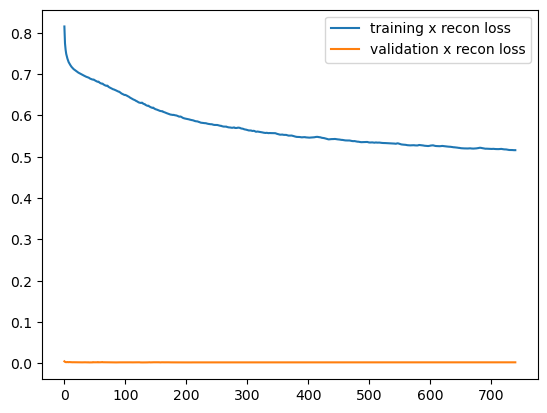

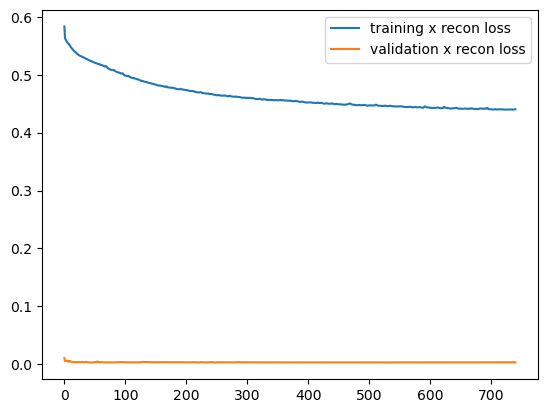

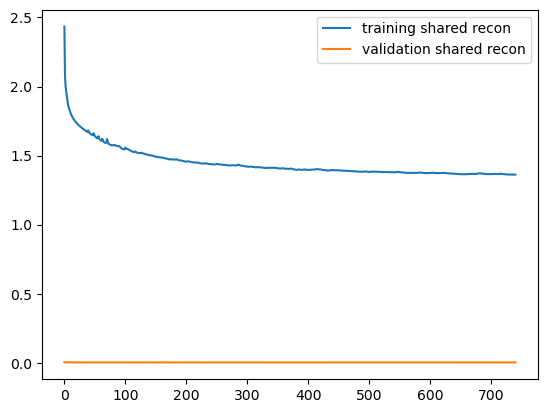

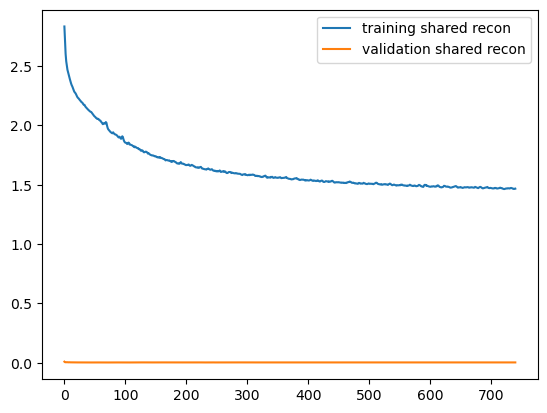

In [14]:

logsavepath_p_dna=os.path.join(logsavepath_train,'dna')
modelsavepath_p_dna=os.path.join(modelsavepath_train,'dna')
plotsavepath_p_dna=os.path.join(plotsavepath_train,'dna')
if not os.path.exists(logsavepath_p_dna):
    os.mkdir(logsavepath_p_dna)
if not os.path.exists(modelsavepath_p_dna):
    os.mkdir(modelsavepath_p_dna)
if not os.path.exists(plotsavepath_p_dna):
    os.mkdir(plotsavepath_p_dna)

logsavepath_p_protein=os.path.join(logsavepath_train,'protein')
modelsavepath_p_protein=os.path.join(modelsavepath_train,'protein')
plotsavepath_p_protein=os.path.join(plotsavepath_train,'protein')
if not os.path.exists(logsavepath_p_protein):
    os.mkdir(logsavepath_p_protein)
if not os.path.exists(modelsavepath_p_protein):
    os.mkdir(modelsavepath_p_protein)
if not os.path.exists(plotsavepath_p_protein):
    os.mkdir(plotsavepath_p_protein)

#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1

allIdx_all=np.arange(proteinNames.size)
np.random.shuffle(allIdx_all)
valIdx_all=allIdx_all[:int(pctVal*proteinNames.size)]
testIdx_all=allIdx_all[int(pctVal*proteinNames.size):(int(pctVal*proteinNames.size)+int(pctTest*proteinNames.size))]
trainIdx_all=allIdx_all[(int(pctVal*proteinNames.size)+int(pctTest*proteinNames.size)):]



for currLatentSize in sharedSizes:
    for dSpecificSize,dfilterSize in dSpecific_filter:
        latent_curr=None
#         if sIdx==0:
#             continue


        print(currLatentSize)
        print(dSpecificSize)
        dna_cShared=hidden5-dfilterSize
        p_cShared=dna_cShared

        loss_kl=optimizer.optimizer_kl
        loss_x=torch.nn.MSELoss()

        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='cnn_vae_pbmc_lord':
            modelcnn_dna_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
            modelcnn_protein_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
            modelcnn_dnaShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
            modelcnn_pShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
        modelcnn_dna_dec.cuda().eval()
        modelcnn_protein_dec.cuda().eval()
        modelcnn_dnaShared_dec.cuda().eval()
        modelcnn_pShared_dec.cuda().eval()
        
        batchsize=328
        latent_shared_dec=torch.nn.Embedding(proteinNames.size,currLatentSize)
        
        latent_protein_dec=torch.nn.Embedding(proteinNames.size,dSpecificSize)
        latent_dna_dec=torch.nn.Embedding(proteinNames.size,dSpecificSize)
        pIDemb_dec=torch.nn.Embedding(nProt, pIDemb_size).cuda()

        
        if loadEpoch is not None:
            with open(os.path.join(modelsavepath_p_dna,'latent_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
                latent_dna_dec.weight=pickle.load(output)
            with open(os.path.join(modelsavepath_p_dna,'latentShared_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
                latent_shared_dec.weight=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'latent_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
                latent_protein_dec.weight=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'pIDemb_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
                pIDemb_dec.weight=pickle.load(output)
            
            with open(os.path.join(modelsavepath_p_dna,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
                stateDict_train_dna_dec=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
                stateDict_train_protein_dec=pickle.load(output)
            with open(os.path.join(modelsavepath_p_dna,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
                stateDict_train_dnaShared_dec=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
                stateDict_train_proteinShared_dec=pickle.load(output)

            modelcnn_dna_dec.load_state_dict(stateDict_train_dna_dec[int(loadEpoch)])
            modelcnn_dnaShared_dec.load_state_dict(stateDict_train_dnaShared_dec[int(loadEpoch)])
            modelcnn_protein_dec.load_state_dict(stateDict_train_protein_dec[int(loadEpoch)])
            modelcnn_pShared_dec.load_state_dict(stateDict_train_proteinShared_dec[int(loadEpoch)])
        latent_shared_dec.weight.requires_grad=False
        
        latent_protein_dec.weight.requires_grad=False
        latent_dna_dec.weight.requires_grad=False
        pIDemb_dec.weight.requires_grad=False



        train_loss=[np.inf]*(epochs)
        train_loss_x_dna=[np.inf]*(epochs)
        train_loss_xShared_dna=[np.inf]*(epochs)
        val_loss=[np.inf]*(epochs)
        val_loss_x_dna=[np.inf]*(epochs)
        val_loss_xShared_dna=[np.inf]*(epochs)

        train_loss_x_protein=[np.inf]*(epochs)
        train_loss_xShared_protein=[np.inf]*(epochs)
        val_loss_x_protein=[np.inf]*(epochs)
        val_loss_xShared_protein=[np.inf]*(epochs)

        t_ep=time.time()

        stateDict_train_dna={}
        stateDict_train_protein={}
        stateDict_train_dnaShared={}
        stateDict_train_proteinShared={}
        
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='cnn_vae_pbmc_lord':
            modelcnn_dna = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,dna_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,pnames.size,'randInit',pIDemb_size)
            modelcnn_protein = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,p_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,pnames.size,'randInit',pIDemb_size)
        modelcnn_dna.cuda()
        modelcnn_protein.cuda()
        
        optimizer_dna = torch.optim.Adam(modelcnn_dna.parameters(), lr=lr, weight_decay=weight_decay)
        optimizer_protein = torch.optim.Adam(modelcnn_protein.parameters(), lr=lr, weight_decay=weight_decay)


        
        
                
        epCounts=0
        for ep in range(epochs):
            train_loss[ep],train_loss_x_dna[ep],train_loss_x_protein[ep],train_loss_xShared_dna[ep],train_loss_xShared_protein[ep],val_loss[ep],val_loss_x_dna[ep],val_loss_x_protein[ep],val_loss_xShared_dna[ep],val_loss_xShared_protein[ep]=train(ep)

            if ep>200 and (val_loss_x_dna[ep]>=val_loss_x_dna[ep-200] or val_loss_x_protein[ep]>=val_loss_x_protein[ep-200]):
                epCounts+=1
            else:
                epCounts=0

            if epCounts>100:
                break


            if ep%saveFreq == (saveFreq-1):
                stateDict_train_dna[ep]=modelcnn_dna.cpu().state_dict()
                stateDict_train_protein[ep]=modelcnn_protein.cpu().state_dict()

            modelcnn_dna.cuda()
            modelcnn_protein.cuda()
            torch.cuda.empty_cache()
        print(' total time: {:.4f}s'.format(time.time() - t_ep))

        with open(os.path.join(modelsavepath_p_dna,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'wb') as output:
            pickle.dump(stateDict_train_dna, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(modelsavepath_p_protein,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'wb') as output:
            pickle.dump(stateDict_train_protein, output, pickle.HIGHEST_PROTOCOL)


        with open(os.path.join(logsavepath_p_dna,'train_loss_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'wb') as output:
            pickle.dump(train_loss, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_dna,'train_loss_x_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'wb') as output:
            pickle.dump(train_loss_x_dna, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_dna,'train_loss_xShared_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'wb') as output:
            pickle.dump(train_loss_xShared_dna, output, pickle.HIGHEST_PROTOCOL)

        with open(os.path.join(logsavepath_p_dna,'val_loss_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'wb') as output:
            pickle.dump(val_loss, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_dna,'val_loss_x_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'wb') as output:
            pickle.dump(val_loss_x_dna, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_dna,'val_loss_xShared_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'wb') as output:
            pickle.dump(val_loss_xShared_dna, output, pickle.HIGHEST_PROTOCOL)

        with open(os.path.join(logsavepath_p_protein,'train_loss_x_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'wb') as output:
            pickle.dump(train_loss_x_protein, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_protein,'val_loss_x_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'wb') as output:
            pickle.dump(val_loss_x_protein, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_protein,'train_loss_xShared_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'wb') as output:
            pickle.dump(train_loss_xShared_protein, output, pickle.HIGHEST_PROTOCOL)
        with open(os.path.join(logsavepath_p_protein,'val_loss_xShared_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'wb') as output:
            pickle.dump(val_loss_xShared_protein, output, pickle.HIGHEST_PROTOCOL)

        totalepoch=np.argmin(np.array(val_loss_x_dna)+np.array(val_loss_x_protein))

        print('loss_val_p: {:.4f}'.format(val_loss_x_protein[totalepoch]),
              'loss_val_c: {:.4f}'.format(val_loss_x_dna[totalepoch]))


        plt.plot(np.arange(epochs),train_loss_x_dna)
        plt.plot(np.arange(epochs),val_loss_x_dna)
        # plt.plot(np.arange(epochs),train_loss_kl_ep)
        plt.legend(['training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_p_dna,'loss_seed3_x_encode'+str(currLatentSize)+'_'+str(dSpecificSize)+'.jpg'))
        plt.show()


        plt.plot(np.arange(epochs),train_loss_x_protein)
        plt.plot(np.arange(epochs),val_loss_x_protein)
        # plt.plot(np.arange(epochs),train_loss_kl_ep)
        plt.legend(['training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_p_protein,'loss_seed3_x_encode'+str(currLatentSize)+'_'+str(dSpecificSize)+'.jpg'))
        plt.show()

        plt.plot(np.arange(epochs),train_loss_xShared_dna)
        plt.plot(np.arange(epochs),val_loss_xShared_dna)
        # plt.plot(np.arange(epochs),train_loss_kl_ep)
        plt.legend(['training shared recon','validation shared recon'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_p_dna,'loss_seed3_xShared_encode'+str(currLatentSize)+'_'+str(dSpecificSize)+'.jpg'))
        plt.show()

        plt.plot(np.arange(epochs),train_loss_xShared_protein)
        plt.plot(np.arange(epochs),val_loss_xShared_protein)
        # plt.plot(np.arange(epochs),train_loss_kl_ep)
        plt.legend(['training shared recon','validation shared recon'],loc='upper right')
        plt.savefig(os.path.join(plotsavepath_p_protein,'loss_seed3_xShared_encode'+str(currLatentSize)+'_'+str(dSpecificSize)+'.jpg'))
        plt.show()










In [13]:
logsavepath_p_dna=os.path.join(logsavepath_train,'dna')
modelsavepath_p_dna=os.path.join(modelsavepath_train,'dna')
plotsavepath_p_dna=os.path.join(plotsavepath_train,'dna')

logsavepath_p_protein=os.path.join(logsavepath_train,'protein')
modelsavepath_p_protein=os.path.join(modelsavepath_train,'protein')
plotsavepath_p_protein=os.path.join(plotsavepath_train,'protein')
#train-test split
np.random.seed(3)
pctVal=0.05
pctTest=0.1

allIdx_all=np.arange(proteinNames.size)
np.random.shuffle(allIdx_all)
valIdx_all=allIdx_all[:int(pctVal*proteinNames.size)]
testIdx_all=allIdx_all[int(pctVal*proteinNames.size):(int(pctVal*proteinNames.size)+int(pctTest*proteinNames.size))]
trainIdx_all=allIdx_all[(int(pctVal*proteinNames.size)+int(pctTest*proteinNames.size)):]



for currLatentSize in sharedSizes:
    for dSpecificSize,dfilterSize in dSpecific_filter:
        latent_curr=None
#         if sIdx==0:
#             continue


        print(currLatentSize)
        print(dSpecificSize)
        dna_cShared=hidden5-dfilterSize
        p_cShared=dna_cShared

        loss_kl=optimizer.optimizer_kl
        loss_x=torch.nn.MSELoss()

        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='cnn_vae_pbmc_lord':
            modelcnn_dna_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
            modelcnn_protein_dec = model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize+dSpecificSize,pIDemb_size)
            modelcnn_dnaShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
            modelcnn_pShared_dec=model.model_cnnvae_conditional.CNN_VAE_decode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,currLatentSize,pIDemb_size)
        modelcnn_dna_dec.cuda().eval()
        modelcnn_protein_dec.cuda().eval()
        modelcnn_dnaShared_dec.cuda().eval()
        modelcnn_pShared_dec.cuda().eval()
        
        batchsize=328
        latent_shared_dec=torch.nn.Embedding(proteinNames.size,currLatentSize)
        
        latent_protein_dec=torch.nn.Embedding(proteinNames.size,dSpecificSize)
        latent_dna_dec=torch.nn.Embedding(proteinNames.size,dSpecificSize)
        pIDemb_dec=torch.nn.Embedding(nProt, pIDemb_size).cuda()

        
        if loadEpoch is not None:
            with open(os.path.join(modelsavepath_p_dna,'latent_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
                latent_dna_dec.weight=pickle.load(output)
            with open(os.path.join(modelsavepath_p_dna,'latentShared_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
                latent_shared_dec.weight=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'latent_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
                latent_protein_dec.weight=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'pIDemb_'+str(currLatentSize)+'_'+str(dSpecificSize)+'_'+str(loadEpoch)), 'rb') as output:
                pIDemb_dec.weight=pickle.load(output)
            
            with open(os.path.join(modelsavepath_p_dna,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
                stateDict_train_dna_dec=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'stateDict_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
                stateDict_train_protein_dec=pickle.load(output)
            with open(os.path.join(modelsavepath_p_dna,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
                stateDict_train_dnaShared_dec=pickle.load(output)
            with open(os.path.join(modelsavepath_p_protein,'stateDictShared_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
                stateDict_train_proteinShared_dec=pickle.load(output)

            modelcnn_dna_dec.load_state_dict(stateDict_train_dna_dec[int(loadEpoch)])
            modelcnn_dnaShared_dec.load_state_dict(stateDict_train_dnaShared_dec[int(loadEpoch)])
            modelcnn_protein_dec.load_state_dict(stateDict_train_protein_dec[int(loadEpoch)])
            modelcnn_pShared_dec.load_state_dict(stateDict_train_proteinShared_dec[int(loadEpoch)])
        latent_shared_dec.weight.requires_grad=False
        
        latent_protein_dec.weight.requires_grad=False
        latent_dna_dec.weight.requires_grad=False
        pIDemb_dec.weight.requires_grad=False



        train_loss=[np.inf]*(epochs)
        train_loss_x_dna=[np.inf]*(epochs)
        train_loss_xShared_dna=[np.inf]*(epochs)
        val_loss=[np.inf]*(epochs)
        val_loss_x_dna=[np.inf]*(epochs)
        val_loss_xShared_dna=[np.inf]*(epochs)

        train_loss_x_protein=[np.inf]*(epochs)
        train_loss_xShared_protein=[np.inf]*(epochs)
        val_loss_x_protein=[np.inf]*(epochs)
        val_loss_xShared_protein=[np.inf]*(epochs)

        t_ep=time.time()

        stateDict_train_dna={}
        stateDict_train_protein={}
        stateDict_train_dnaShared={}
        stateDict_train_proteinShared={}
        
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.enabled = True
        if modelname_train=='cnn_vae_pbmc_lord':
            modelcnn_dna = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,dna_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,pnames.size,'randInit',pIDemb_size)
            modelcnn_protein = model.model_cnnvae_conditional.CNN_VAE_split_encode_pIDemb(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5,p_cShared,p_cShared*hidden5_xy*hidden5_xy, (hidden5-p_cShared)*hidden5_xy*hidden5_xy,currLatentSize,dSpecificSize,pnames.size,'randInit',pIDemb_size)
        modelcnn_dna.cuda()
        modelcnn_protein.cuda()

1024
200


In [14]:
with open(os.path.join(modelsavepath_p_dna,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_dna=pickle.load( output)
with open(os.path.join(modelsavepath_p_protein,'stateDict_encode_'+str(currLatentSize)+'_'+str(dSpecificSize)), 'rb') as output:
    stateDict_train_protein=pickle.load(output)


In [15]:
stateDict_train_dna.keys()

dict_keys([99, 199, 299, 399, 499, 599, 699])

In [16]:
modelcnn_dna.load_state_dict(stateDict_train_dna[399])
modelcnn_protein.load_state_dict(stateDict_train_protein[399])

<All keys matched successfully>

In [17]:
def modeSub_torch(img_c):
    intensity,intCounts=torch.unique(img_c,return_counts=True)
    modeint=intensity[torch.argmax(intCounts)]
#     modeint=np.percentile(img_c,75)
    img_c=img_c-modeint
    img_c[img_c<0]=0
    img_c=img_c/torch.max(img_c)
#     print(modeint)
    return img_c

In [18]:
loss_x_noReduction=torch.nn.L1Loss(reduction='sum')
with torch.no_grad():
    modelcnn_dna.eval()
    modelcnn_protein.eval()
    modelcnn_dna.cuda()
    modelcnn_protein.cuda()



    loss_val_all=0
    loss_x_val_all_dna=0
    loss_x_valShared_all_dna=0
    loss_x_val_all_protein=0
    loss_x_valShared_all_protein=0
    loss_shared={}
    loss_shared['gh2ax']=0
    loss_shared['cd16']=0
    loss_shared['cd3']=0
    loss_shared['cd4']=0
    loss_shared['cd8']=0
    loss_shared['lamin']=0
    loss_full={}
    loss_full['gh2ax']=0
    loss_full['cd16']=0
    loss_full['cd3']=0
    loss_full['cd4']=0
    loss_full['cd8']=0
    loss_full['lamin']=0
    nvalBatches=int(np.ceil(valIdx.shape[0]/batchsize))
    for i in range(nvalBatches):
        valIdx_i=valIdx[i*batchsize:min((i+1)*batchsize,valIdx.shape[0])]
        valtarget_protein=torch.tensor(imgsP_val[valIdx_i]).cuda().float()
        valtarget_dna=torch.tensor(imgsC_val[valIdx_i]).cuda().float()
        valInput_ID=plabels_val[valIdx_i].cuda()
        valIdx_i=torch.tensor(valIdx_i)

        reconShared_dna_l,recon_dna_l= modelcnn_dna(valtarget_dna,valInput_ID)
        reconShared_protein_l,recon_protein_l= modelcnn_protein(valtarget_protein,valInput_ID)

        recon_dna= modelcnn_dna_dec(torch.cat((reconShared_dna_l,recon_dna_l),dim=1),pIDemb_dec(valInput_ID))
        reconShared_dna=modelcnn_dnaShared_dec(reconShared_dna_l,pIDemb_dec(valInput_ID))
        recon_protein= modelcnn_protein_dec(torch.cat((reconShared_protein_l,recon_protein_l),dim=1),pIDemb_dec(valInput_ID))
        reconShared_protein=modelcnn_pShared_dec(reconShared_protein_l,pIDemb_dec(valInput_ID))


        loss_x_val_protein=loss_x(recon_protein, valtarget_protein)
        loss_xShared_val_protein=loss_x(reconShared_protein,valtarget_protein)
        loss_x_val_dna=loss_x(recon_dna, valtarget_dna)
        loss_xShared_val_dna=loss_x(reconShared_dna,valtarget_dna)

        loss=loss_x_val_protein+loss_xShared_val_protein+loss_x_val_dna+loss_xShared_val_dna

        loss_x_val_all_dna+=loss_x_val_dna.item()
        loss_x_valShared_all_dna+=loss_xShared_val_dna.item()
        loss_x_val_all_protein+=loss_x_val_protein.item()
        loss_x_valShared_all_protein+=loss_xShared_val_protein.item()
        loss_val_all+=loss.item()
        
        for p in np.unique(proteinNames_val[valIdx_i]):
            loss_full[p]+=loss_x_noReduction(modeSub_torch(recon_protein[proteinNames_val[valIdx_i]==p]), valtarget_protein[proteinNames_val[valIdx_i]==p]).item()/(valtarget_dna.shape[2]*valtarget_dna.shape[3])
            loss_shared[p]+=loss_x_noReduction(modeSub_torch(reconShared_protein[proteinNames_val[valIdx_i]==p]),valtarget_protein[proteinNames_val[valIdx_i]==p]).item()/(valtarget_dna.shape[2]*valtarget_dna.shape[3])
        

    loss_x_val_all_dna=loss_x_val_all_dna/nvalBatches
    loss_x_valShared_all_dna=loss_x_valShared_all_dna/nvalBatches
    loss_x_val_all_protein=loss_x_val_all_protein/nvalBatches
    loss_x_valShared_all_protein=loss_x_valShared_all_protein/nvalBatches
    loss_val_all=loss_val_all/nvalBatches
    
    for p in np.unique(proteinNames_val):
        print(p)
        loss_shared[p]=loss_shared[p]/np.sum(proteinNames_val==p)
        loss_full[p]=loss_full[p]/np.sum(proteinNames_val==p)
        print('shared',loss_shared[p])
        print('full',loss_full[p])

cd16
shared 0.03447040978654042
full 0.0538639142563807
cd3
shared 0.04581888610946721
full 0.04435368858534714
cd4
shared 0.029569351001026367
full 0.03009239909203187
cd8
shared 0.028449616456841787
full 0.029643171691119758
gh2ax
shared 0.02271028910913775
full 0.018934404177050435
lamin
shared 0.03750876938143084
full 0.03614461527716729


In [23]:
loss_x_val_all_dna

0.0024031442378393626

In [24]:
loss_x_valShared_all_dna

0.0024084384256804533